In [ ]:
pip install sklearn matplotlib

In [ ]:
pip install transformers

In [ ]:
pip install nltk

In [ ]:
import nltk
nltk.download('punkt')

In [ ]:
import os
import json
import numpy as np
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from tqdm.notebook import tqdm
import seaborn as sns
from nltk.tokenize import sent_tokenize
import nltk
from nltk.tokenize import sent_tokenize
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Initialize tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

model.config.output_hidden_states = True

Token indices sequence length is longer than the specified maximum sequence length for this model (19421 > 512). Running this sequence through the model will result in indexing errors


      manifesto_id  Token Length
2561  61320_196011         19421
2562  61620_196011         12983
2563  61320_196411          6334
2564  61620_196411         11106
2565  61320_196811         20131
2566  61620_196811         12365
2567  61320_197211         31238
2568  61620_197211         29575
2569  61320_197611         25462
2570  61620_197611         24271
2571  61320_198011         46021
2572  61620_198011         41919
2573  61320_198411         53056
2574  61620_198411         33999
2575  61320_198811          5919
2576  61620_198811         43892
2577  61320_199211         10534
2578  61620_199211         35185
2579  61320_199611         19496
2580  61620_199611         34473
2581  61320_200011         29162
2582  61620_200011         42764
2583  61320_200411         21481
2584  61620_200411         50637
2585  61320_200811         31642
2586  61620_200811         28520
2587  61320_201211         30241
2588  61620_201211         38275
2589  61320_201611         31952
2590  6162

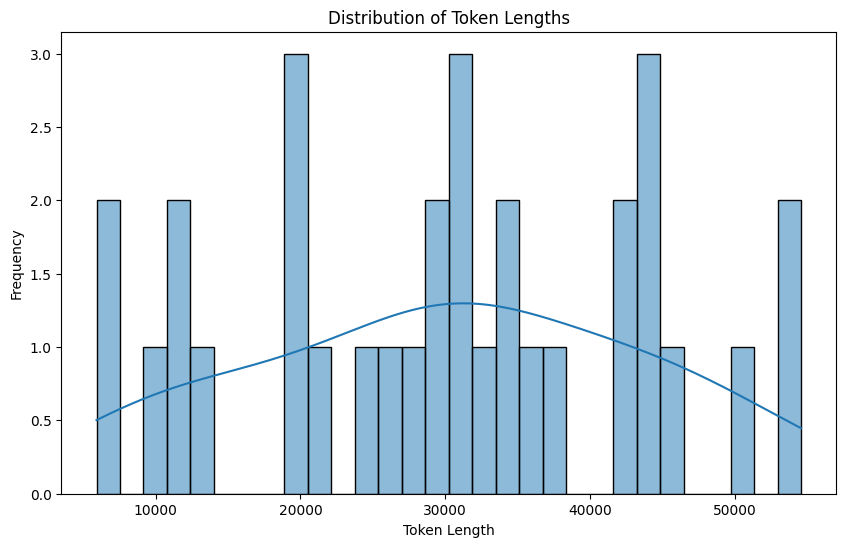

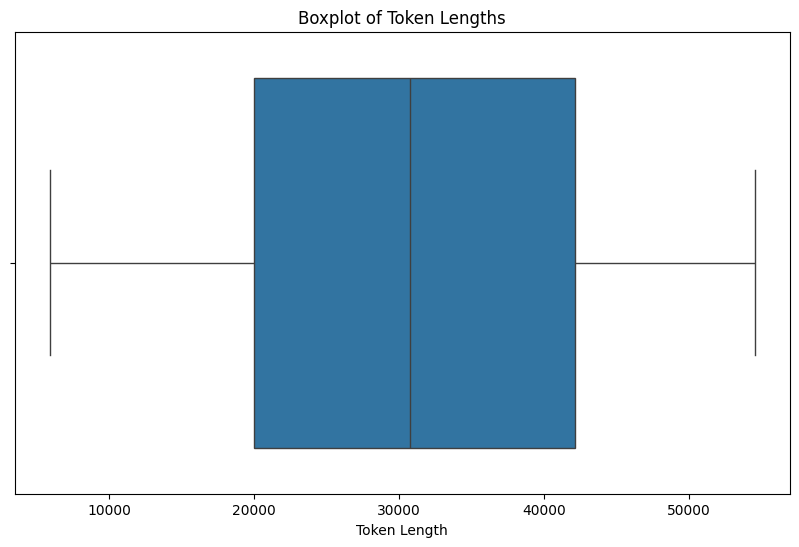

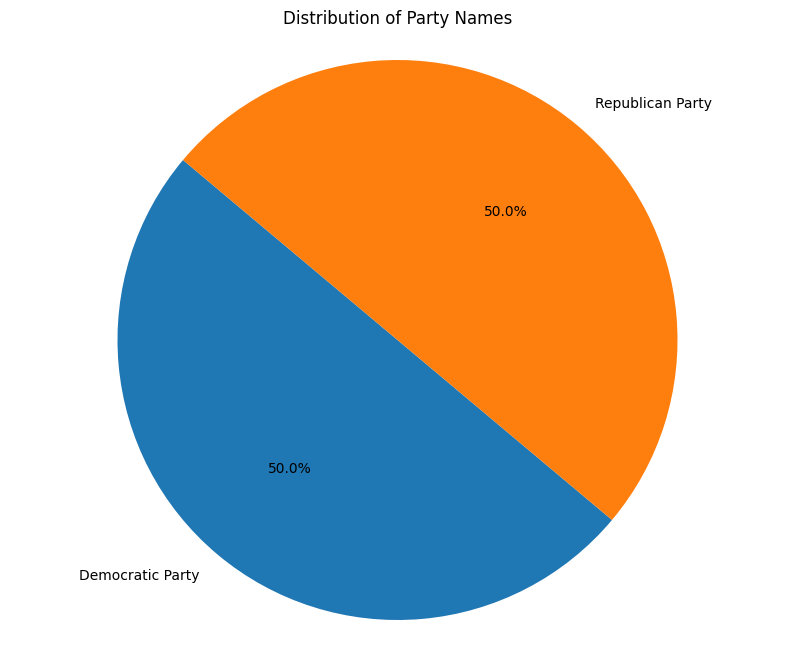

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

# Path to the JSON file
json_file_path = '/content/us_filtered.json'

# Load the JSON file
with open(json_file_path, 'r') as file:
    data = json.load(file)

# Convert to DataFrame
df = pd.DataFrame(data)

# Filter out entries with no text
df = df[df['text'].notna()]

# Calculate token lengths for each text entry
df['Token Length'] = df.apply(lambda row: len(tokenizer.encode(row['text'], add_special_tokens=True)), axis=1)

# Display the DataFrame with Token Lengths
print(df[['manifesto_id', 'Token Length']])

# Statistical measures
print("\nStatistical Measures:")
print(f"Mean Token Length: {df['Token Length'].mean()}")
print(f"Median Token Length: {df['Token Length'].median()}")
print(f"Maximum Token Length: {df['Token Length'].max()}")
print(f"Minimum Token Length: {df['Token Length'].min()}")

# Plotting Token Length Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Token Length'], bins=30, kde=True)
plt.title('Distribution of Token Lengths')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

# Boxplot for Token Lengths
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Token Length'])
plt.title('Boxplot of Token Lengths')
plt.xlabel('Token Length')
plt.show()

# Count the occurrences of each party name
party_counts = df['partyname'].value_counts()

# Plotting
plt.figure(figsize=(10, 8))
plt.pie(party_counts, labels=party_counts.index, autopct='%1.1f%%', startangle=140)
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of Party Names')
plt.show()

In [ ]:
def get_model_prediction(text):
    tokenized_inputs = tokenizer(text, truncation=True, return_tensors='pt', max_length=512)
    inputs = {'input_ids': tokenized_inputs['input_ids'], 'attention_mask': tokenized_inputs['attention_mask']}
    outputs = model(**inputs)
    logits = outputs[0]
    probs = logits.softmax(dim=-1)[0].tolist()
    score = probs[0] * 1/6 + probs[1] * 3/6 + probs[2] * 5/6
    #stance_mapping = {0: "left", 1: "center", 2: "right"}
    #predicted_stance = stance_mapping[probs.index(max(probs))]

    # Get the embeddings from one of the last layers
    embeddings = outputs.hidden_states[-2][0].mean(dim=0)

    return embeddings, probs, score

In [ ]:
# Map 'partyname' to 'right' or 'left'
party_mapping = {'Republican Party': 'right', 'Democratic Party': 'left'}
df['mapped_party'] = df['partyname'].map(party_mapping)

In [ ]:
df

In [ ]:
# Function to apply predictions
def apply_prediction(row):
    embeddings, probs, score = get_model_prediction(row['text'])
    row['embeddings'] = embeddings.detach().numpy()
    row['left_prob'] = probs[0]
    row['center_prob'] = probs[1]
    row['right_prob'] = probs[2]
    row['score'] = score
    row['predicted_stance'] = 'right' if score > 0.5 else 'left'
    return row

In [ ]:
# Apply the function with tqdm for progress tracking
tqdm.pandas(desc="Processing speeches")
df_processed = df.progress_apply(apply_prediction, axis=1)

# Write the updated DataFrame to a new CSV file
df_processed.to_csv('updated_dataset_new.csv', index=False)

Processing speeches:   0%|          | 0/32 [00:00<?, ?it/s]

accuracy

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('updated_dataset_new.csv')

In [ ]:

# Calculate accuracy
correct_predictions = (df['mapped_party'] == df['predicted_stance']).sum()
total_predictions = len(df)

accuracy = correct_predictions / total_predictions
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 43.75%


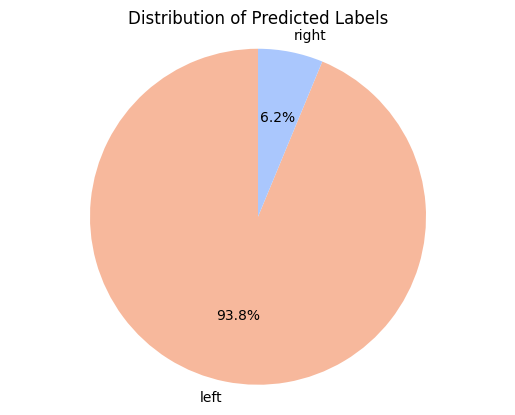

In [ ]:
# Calculate label counts from the "predicted_stance" column
label_counts = df['predicted_stance'].value_counts()

# Use the "coolwarm" color palette from seaborn
colors = sns.color_palette("coolwarm", len(label_counts))
colors = colors[::-1]

# Plot the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.title("Distribution of Predicted Labels")
plt.show()

<ipython-input-26-dc0662d99b80>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['score'], kde=True, palette="coolwarm")


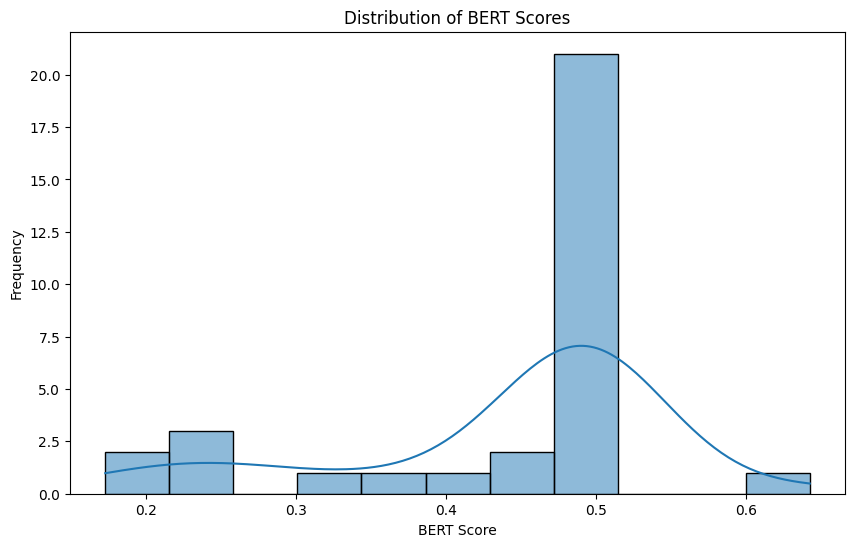

In [ ]:
# BERT Score Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True, palette="coolwarm")
plt.title('Distribution of BERT Scores')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.show()

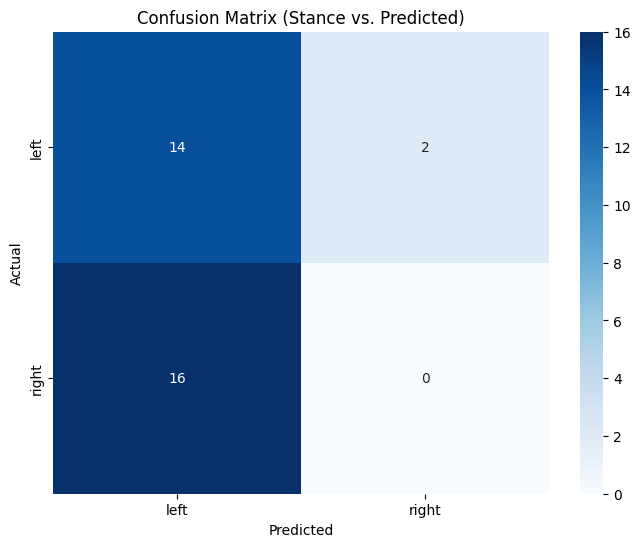

In [ ]:
# Create a confusion matrix
actual_labels = df['mapped_party']
predicted_labels = df['predicted_stance']

unique_labels = np.unique(actual_labels)

conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stance vs. Predicted)')
plt.show()

In [ ]:

# Function to chunk text by sentences
def chunk_text_by_sentences(text, max_tokens):
    sentences = sent_tokenize(text)
    token_chunks = []
    current_chunk = []

    for sentence in sentences:
        sentence_tokens = tokenizer.encode(sentence, add_special_tokens=False)
        if len(current_chunk) + len(sentence_tokens) > max_tokens:
            token_chunks.append(current_chunk)
            current_chunk = sentence_tokens
        else:
            current_chunk.extend(sentence_tokens)

    if current_chunk:
        token_chunks.append(current_chunk)

    return token_chunks


In [ ]:
def get_model_prediction(text):
    probs_list = []
    score_list = []
    embeddings_list = []
    #for chunk in text:
        # Convert token ids to text
    chunk_text = tokenizer.decode(text)

    # Tokenize the text
    inputs = tokenizer(chunk_text, return_tensors='pt', padding='max_length', truncation=True, max_length=512)


    # Pass the inputs to the model
    outputs = model(**inputs)
    logits = outputs.logits
    probs = logits.softmax(dim=-1).squeeze().tolist()
    probs_list.append(probs)
    score = probs[0] * 1/6 + probs[1] * 3/6 + probs[2] * 5/6
    score_list.append(score)
    # Get the embeddings from one of the last layers
    embeddings = outputs.hidden_states[-2][0].mean(dim=0)
    embeddings_list.append(embeddings)



    return embeddings, probs, score

In [ ]:
# Function to apply predictions
def apply_prediction(row):
    embeddings, probs, score = get_model_prediction(row['text_tokens'])
    row['embeddings'] = embeddings.detach().numpy()
    row['left_prob'] = probs[0]
    row['center_prob'] = probs[1]
    row['right_prob'] = probs[2]
    row['score'] = score
    row['predicted_stance'] = 'right' if score > 0.5 else 'left'
    return row

In [ ]:
# Function to create a new DataFrame with each chunk as a separate row
def create_chunked_dataframe(df):
    new_rows = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0], desc="Chunking Texts"):
        text = str(row['text'])
        text_chunks = chunk_text_by_sentences(text, max_tokens=512)
        for chunk in text_chunks:
            new_row = row.copy()
            new_row['text'] = tokenizer.decode(chunk)
            new_row['text_tokens'] = chunk
            new_rows.append(new_row)
    return pd.DataFrame(new_rows)

In [ ]:
# Create a new DataFrame with chunks
df_chunked = create_chunked_dataframe(df)

Chunking Texts:   0%|          | 0/32 [00:00<?, ?it/s]

In [ ]:
df_chunked

,countryname,party,partyname,date,keys,manifesto_id,text,Token Length,text_tokens
2561,United States,61320,Democratic Party,196011,61320_196011,61320_196011,"In 1796, in America's first contested national...",19421,"[1130, 14342, 117, 1107, 1738, 112, 188, 1148,..."
2561,United States,61320,Democratic Party,196011,61320_196011,61320_196011,They have also admitted that our conventional ...,19421,"[1220, 1138, 1145, 4120, 1115, 1412, 7228, 176..."
2561,United States,61320,Democratic Party,196011,61320_196011,61320_196011,We shall continue to adhere to our treaty obli...,19421,"[1284, 4103, 2760, 1106, 8050, 12807, 1106, 14..."
2561,United States,61320,Democratic Party,196011,61320_196011,61320_196011,The new Democratic Administration will plan fo...,19421,"[1109, 1207, 2978, 4918, 1209, 2197, 1111, 112..."
2561,United States,61320,Democratic Party,196011,61320_196011,61320_196011,The Democratic Party welcomes the study now be...,19421,"[1109, 2978, 1786, 7236, 1116, 1103, 2025, 120..."
...,...,...,...,...,...,...,...,...,...
2592,United States,61620,Republican Party,202011,61620_202011,61620_202011,"The United States must stand with leaders, lik...",44113,"[1109, 1244, 1311, 1538, 2484, 1114, 3478, 117..."
2592,United States,61620,Republican Party,202011,61620_202011,61620_202011,"Over the last 50 years, the level of private i...",44113,"[3278, 1103, 1314, 1851, 1201, 117, 1103, 1634..."
2592,United States,61620,Republican Party,202011,61620_202011,61620_202011,Republican policy will reflect the fact that t...,44113,"[3215, 2818, 1209, 7977, 1103, 1864, 1115, 110..."
2592,United States,61620,Republican Party,202011,61620_202011,61620_202011,They will continue until the world understands...,44113,"[1220, 1209, 2760, 1235, 1103, 1362, 21744, 11..."


In [ ]:
# Apply predictions to each chunk
tqdm.pandas(desc="Processing Chunks")
df_processed = df_chunked.progress_apply(apply_prediction, axis=1)

Processing Chunks:   0%|          | 0/1970 [00:00<?, ?it/s]

In [ ]:
# Write the updated chunked DataFrame to a new CSV file
df_processed.to_csv('manifesto_chunked_results.csv', index=False)

Accuracy

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('manifesto_chunked_results.csv')

Full

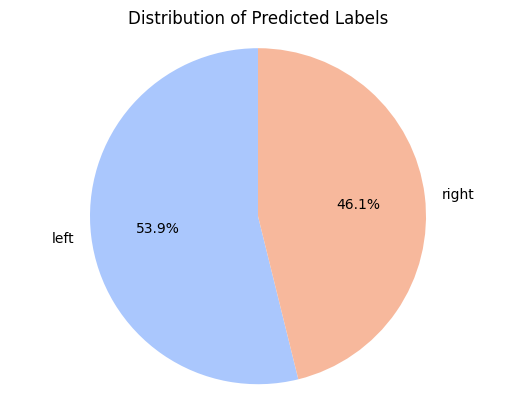

In [ ]:
# Calculate label counts from the "predicted_stance" column
label_counts = df['predicted_stance'].value_counts()

# Use the "coolwarm" color palette from seaborn
colors = sns.color_palette("coolwarm", len(label_counts))

# Plot the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.title("Distribution of Predicted Labels")
plt.show()

<ipython-input-13-dc0662d99b80>:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.histplot(df['score'], kde=True, palette="coolwarm")


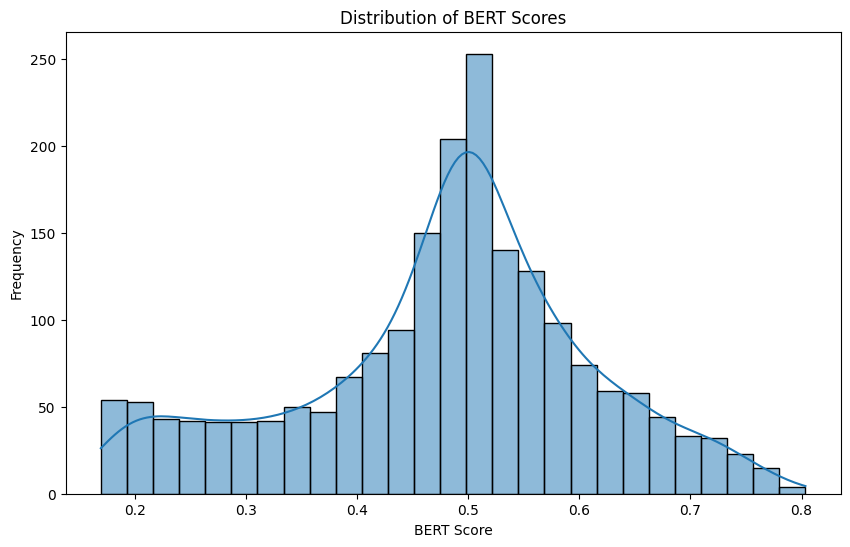

In [ ]:
# BERT Score Distribution Plot
plt.figure(figsize=(10, 6))
sns.histplot(df['score'], kde=True, palette="coolwarm")
plt.title('Distribution of BERT Scores')
plt.xlabel('BERT Score')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# Map to 'left' or 'right'
df['mapped_party'] = df['partyname'].map({'Democratic Party': 'left', 'Republican Party': 'right'})

# Calculate accuracy
accuracy = (df['mapped_party'] == df['predicted_stance']).mean()

print(f'Accuracy: {accuracy}')

Accuracy: 0.5883248730964467


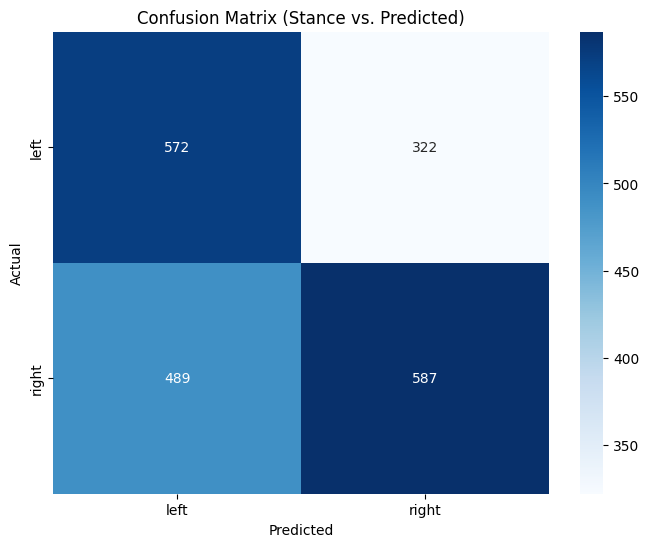

In [ ]:
# Create a confusion matrix
actual_labels = df['mapped_party']
predicted_labels = df['predicted_stance']

unique_labels = np.unique(actual_labels)

conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stance vs. Predicted)')
plt.show()

embeddings

In [ ]:
# Function to convert string embeddings to numpy arrays
def convert_embedding(embedding_str):
    return np.array([float(num) for num in embedding_str.strip('[]').split()])

# Apply the function to convert embeddings
df['embeddings_vis'] = df['embeddings'].apply(convert_embedding)
embeddings = np.vstack(df['embeddings_vis'])

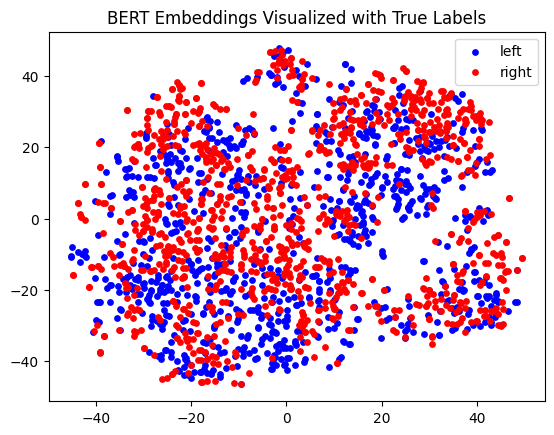

In [ ]:
import matplotlib.pyplot as plt

# Dimensionality Reduction
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(embeddings)

# Plotting
unique_labels = set(df['mapped_party'])
for label in unique_labels:
    indices = [i for i, x in enumerate(df['mapped_party']) if x == label]
    color = 'red' if label == 'right' else 'blue'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1],
                c=color, label=label, s=15)

plt.legend()
plt.title("BERT Embeddings Visualized with True Labels")
plt.show()

Median

In [ ]:
# Read the CSV file into a DataFrame
df = pd.read_csv('manifesto_chunked_results.csv')

In [ ]:
# Map to 'left' or 'right'
df['mapped_party'] = df['partyname'].map({'Democratic Party': 'left', 'Republican Party': 'right'})

# Group by 'keys' and calculate the median score
median_scores = df.groupby('keys')['score'].median()

# Make predictions based on the median score
predictions = median_scores.apply(lambda x: 'right' if x > 0.5 else 'left')

grouped = df.groupby('keys')
#Create a DataFrame for actual vs predicted
actual_vs_predicted = pd.DataFrame({
    'actual': grouped['mapped_party'].first(),
    'predicted': predictions
})

accuracy = (actual_vs_predicted['actual'] == actual_vs_predicted['predicted']).mean()

print(f'Accuracy: {accuracy}')

Accuracy: 0.6875


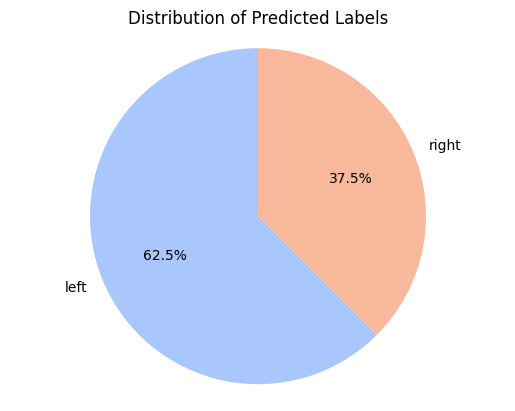

In [ ]:
# Calculate label counts from the "predicted_stance" column
label_counts = predictions.value_counts()

# Use the "coolwarm" color palette from seaborn
colors = sns.color_palette("coolwarm", len(label_counts))

# Plot the pie chart
fig1, ax1 = plt.subplots()
ax1.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90, colors = colors)
ax1.axis('equal')  # Equal aspect ratio ensures that the pie chart is circular.
plt.title("Distribution of Predicted Labels")
plt.show()

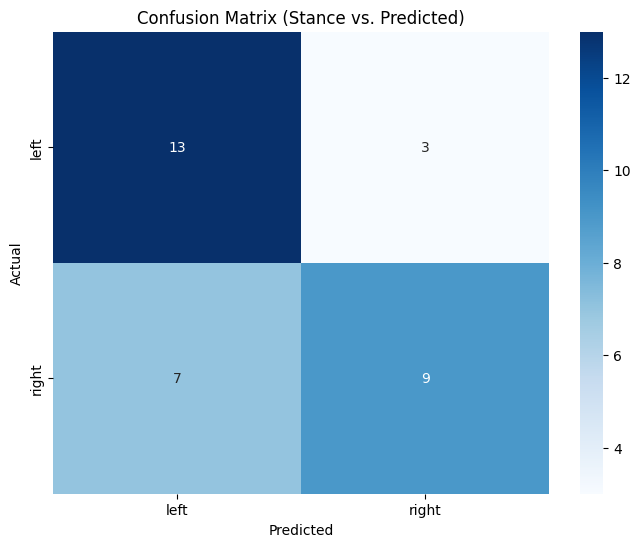

In [ ]:
# Create a confusion matrix
actual_labels = actual_vs_predicted['actual']
predicted_labels = actual_vs_predicted['predicted']

unique_labels = np.unique(actual_labels)

conf_matrix = confusion_matrix(actual_labels, predicted_labels, labels=unique_labels)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Stance vs. Predicted)')
plt.show()

In [ ]:
# Function to convert string embeddings to numpy arrays
def convert_embedding(embedding_str):
    return np.array([float(num) for num in embedding_str.strip('[]').split()])

# Apply the function to convert embeddings
df['embeddings_vis'] = df['embeddings'].apply(convert_embedding)

Median Embeddings

In [ ]:
def median_of_arrays(group):
    arrays = np.stack(group)
    return np.median(arrays, axis=0)

# Apply this function to each group
median_embeddings = grouped['embeddings_vis'].apply(median_of_arrays)

In [ ]:
len(median_embeddings_array)

32

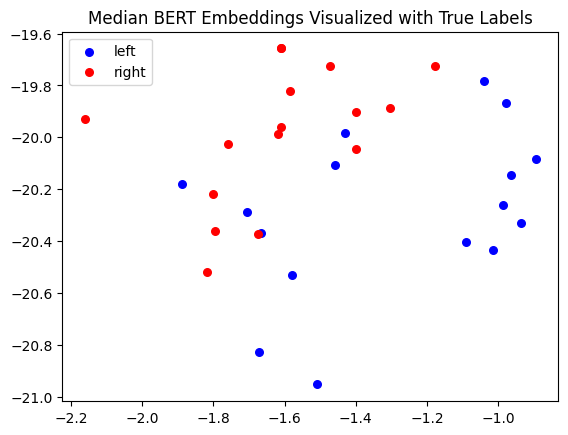

In [ ]:
# Convert mean embeddings to a format suitable for TSNE
median_embeddings_array = np.array(median_embeddings.tolist())

# Dimensionality Reduction
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(median_embeddings_array)

group_labels = grouped['mapped_party'].first()

for label in set(group_labels):
    indices = [i for i, x in enumerate(group_labels) if x == label]
    color = 'red' if label == 'right' else 'blue' if label == 'left' else 'green'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1],
                c=color, label=label, s = 30)

plt.legend()
plt.title("Median BERT Embeddings Visualized with True Labels")
plt.show()

Mean

In [ ]:
grouped = df.groupby('keys')
mean_embeddings = grouped['embeddings_vis'].apply(np.mean)

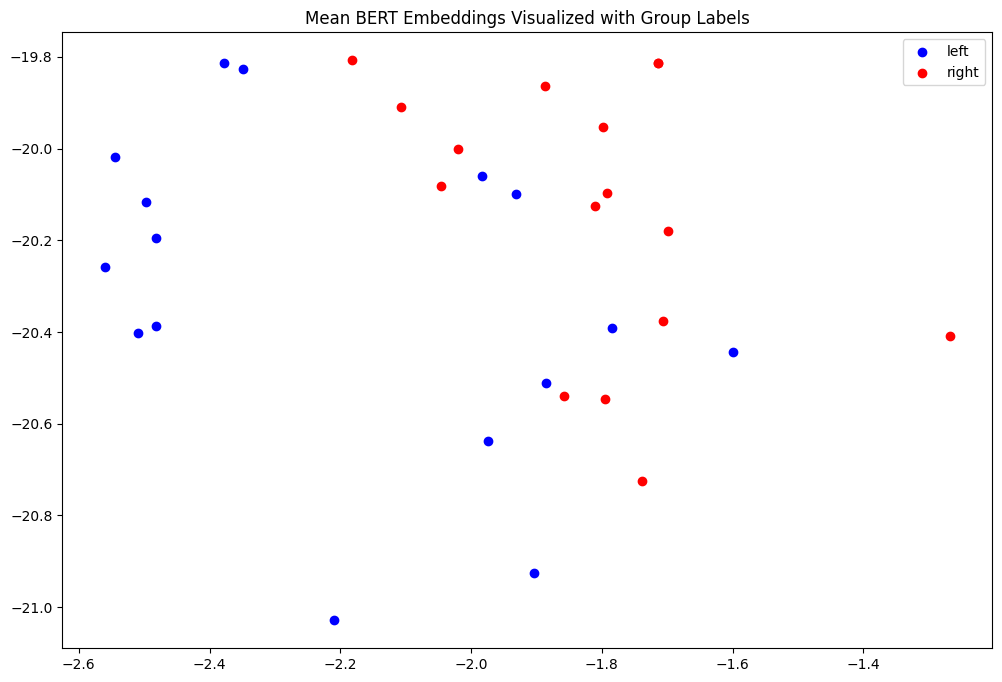

In [ ]:
# Convert mean embeddings to a format suitable for TSNE
mean_embeddings_array = np.array(mean_embeddings.tolist())

# Dimensionality Reduction
embeddings_reduced = TSNE(n_components=2, random_state=42).fit_transform(mean_embeddings_array)

# Plotting
plt.figure(figsize=(12, 8))

#
group_labels = grouped['mapped_party'].first()

for label in set(group_labels):
    indices = [i for i, x in enumerate(group_labels) if x == label]
    color = 'red' if label == 'right' else 'blue' if label == 'left' else 'green'
    plt.scatter(embeddings_reduced[indices, 0], embeddings_reduced[indices, 1],
                c=color, label=label, alpha = 1)

plt.legend()
plt.title("Mean BERT Embeddings Visualized with Group Labels")
plt.show()